In [1]:
import pandas as pd
import numpy as np

## Preprocessing Gas Price Data

In [2]:
gas_dataset = pd.read_csv('gas_dataset.csv')

In [3]:
gas_dataset

,open,close,low,high,avgGas,timestamp
0,51.4000,50.4000,30.2900,63.0500,80868.519046,2022-04-26T13:34:21.641Z
1,74.9800,49.4400,36.8900,119.4100,85449.256791,2022-04-26T14:00:09.549Z
2,59.3500,72.7700,42.2300,121.5400,82192.413722,2022-04-26T15:00:08.630Z
3,82.8200,70.2500,36.0000,98.4700,82451.786800,2022-04-26T16:01:05.379Z
4,68.5000,59.6100,27.3600,84.8300,84236.446559,2022-04-26T17:00:58.575Z
...,...,...,...,...,...,...
5479,14.3790,14.0238,12.0000,18.1021,166736.391980,2022-12-11T05:00:28.462Z
5480,14.8214,14.6782,12.0000,17.8660,157472.907955,2022-12-11T06:00:33.482Z
5481,14.6852,14.7600,12.5715,20.0906,115399.969702,2022-12-11T07:00:37.563Z
5482,13.7311,13.6790,12.2000,16.6647,119084.124717,2022-12-11T08:00:42.075Z


In [4]:
gas_average = gas_dataset.apply(lambda x: round((x['low'] + x['high']) / 2, 4), axis = 1)

In [5]:
gas_average.describe()

count    5484.000000
mean       38.881064
std       140.416634
min         3.520000
25%        13.560925
50%        21.802500
75%        39.437500
max      5892.560000
dtype: float64

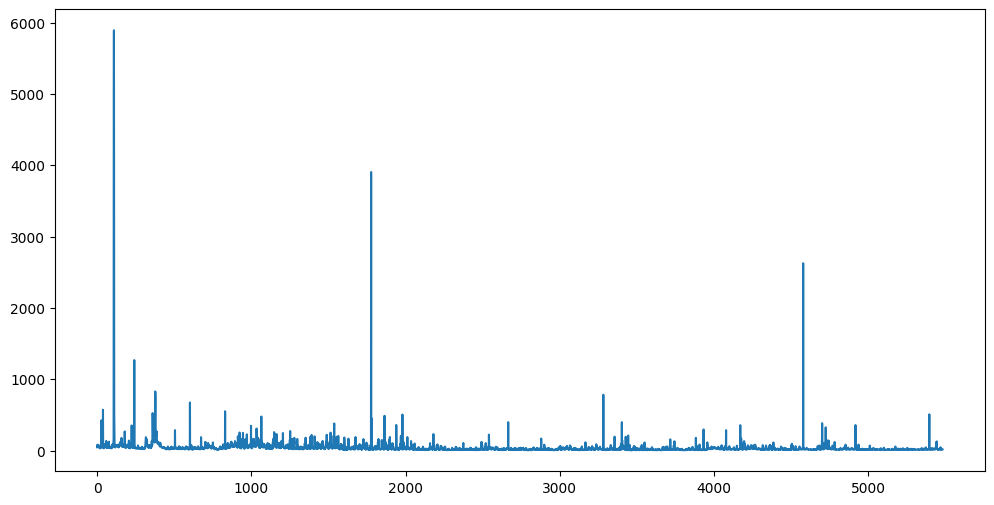

In [6]:
gas_average.plot(figsize = (12,6));

In [7]:
gas_average = gas_average.apply(lambda x: x if x < 1000 else np.nan)

In [8]:
gas_average.describe()

count    5478.000000
mean       34.822632
std        47.757974
min         3.520000
25%        13.556275
50%        21.792500
75%        39.315000
max       828.400000
dtype: float64

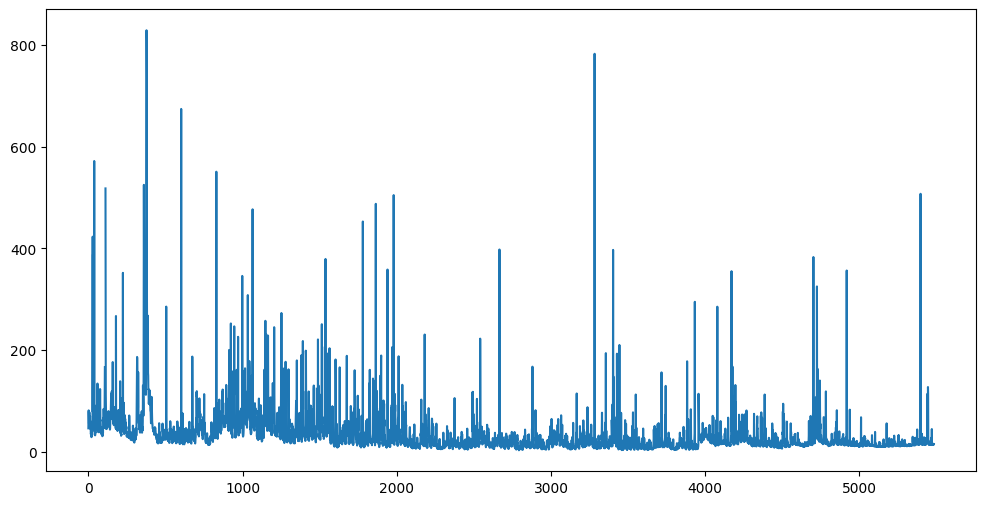

In [9]:
gas_average.plot(figsize = (12,6));

In [10]:
gas_average = gas_average.apply(lambda x: x if x < 300 else np.nan)

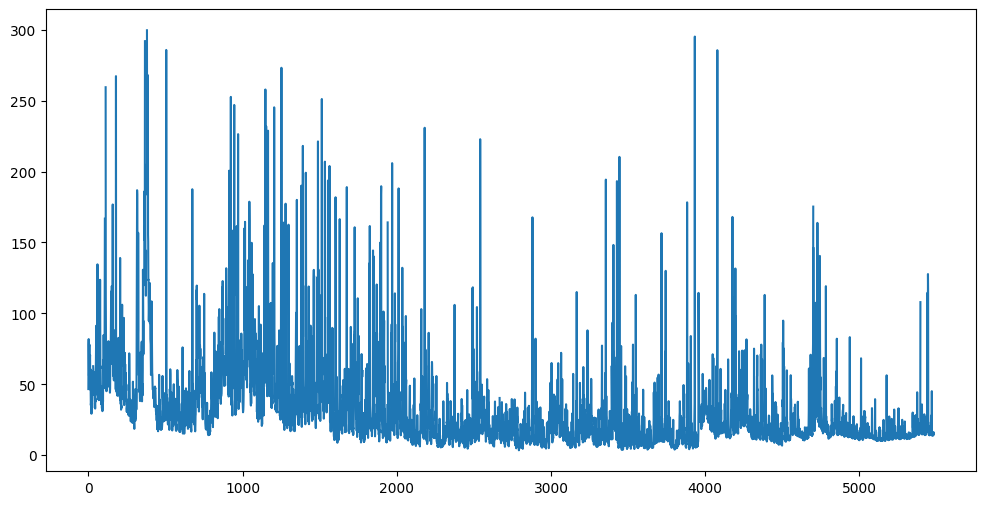

In [11]:
gas_average.plot(figsize = (12,6));

In [12]:
sum(gas_average.isnull()) # 39 outliers

39

In [13]:
df_average = pd.DataFrame({'average_gas_fee': gas_average, 'avgGas': gas_dataset['avgGas'], 'timestamp' : gas_dataset['timestamp']})

In [14]:
df_average.head()

,average_gas_fee,avgGas,timestamp
0,46.670,80868.519046,2022-04-26T13:34:21.641Z
1,78.150,85449.256791,2022-04-26T14:00:09.549Z
2,81.885,82192.413722,2022-04-26T15:00:08.630Z
3,67.235,82451.786800,2022-04-26T16:01:05.379Z
4,56.095,84236.446559,2022-04-26T17:00:58.575Z


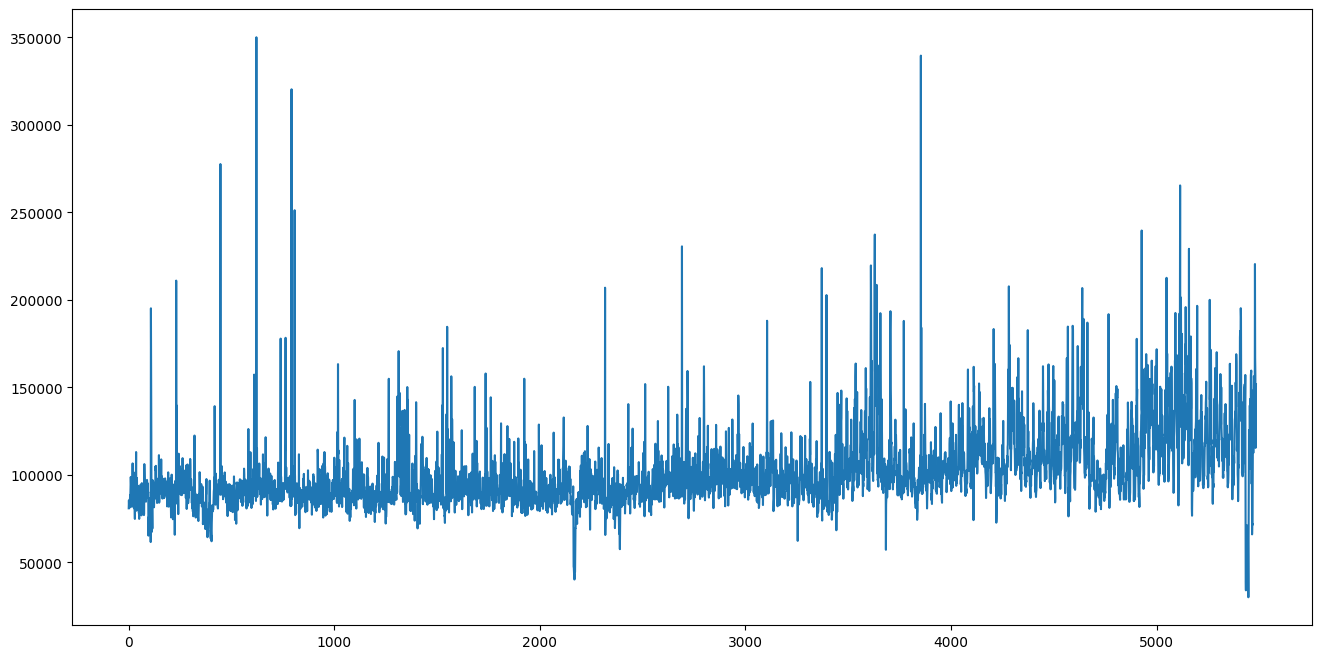

In [15]:
df_average.avgGas.plot(figsize = (16,8));

In [16]:
df_average.avgGas.describe()

count      5484.000000
mean     101155.490365
std       21474.275711
min       30026.196330
25%       88694.940345
50%       95409.490567
75%      106952.911987
max      350025.322828
Name: avgGas, dtype: float64

In [17]:
df_average['avgGas'] = df_average.avgGas.apply(lambda x: x if x < 200000 and x > 60000 else np.nan)

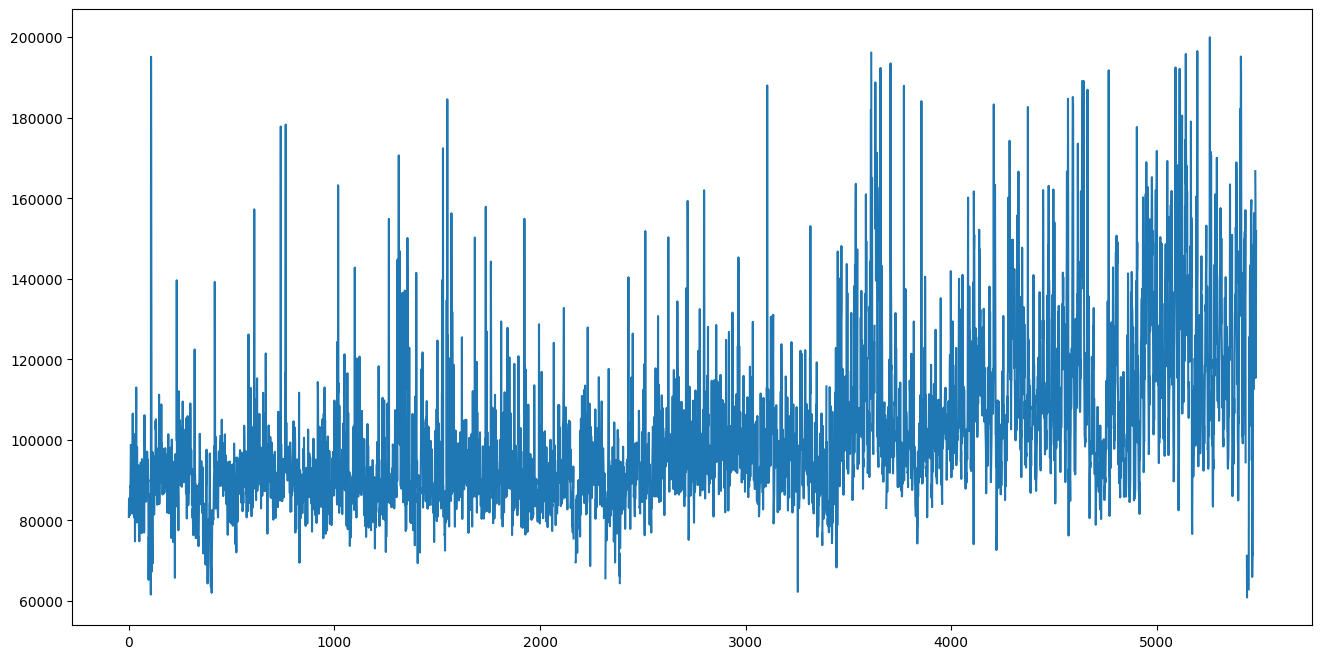

In [18]:
df_average.avgGas.plot(figsize = (16,8));

In [19]:
df_average['average_gas_fee'] = df_average['average_gas_fee'].fillna(method = 'ffill')
df_average['avgGas'] = df_average['avgGas'].fillna(method = 'ffill')

In [20]:
sum(df_average['average_gas_fee'].isnull() == True)

0

In [21]:
# timestamp transformation
def fun(x):
    x = x.replace('T', ' ')[:-11]
    return pd.to_datetime(x, format = '%Y-%m-%d %H')

df_average['timestamp'] = df_average['timestamp'].apply(fun)

In [22]:
check = []
for index in range(len(df_average) - 1):
    var1 = int(str(df_average['timestamp'][index])[-8:-6]) # extract hour
    var2 = int(str(df_average['timestamp'][index+1])[-8:-6])
    if (var2 - var1) % 24 != 1:
        check.extend([index, index + 1])

In [23]:
df_average.loc[check]

,average_gas_fee,avgGas,timestamp
1383,23.8000,77567.419140,2022-06-23 04:00:00
1384,20.0250,85869.120139,2022-06-23 11:00:00
2568,31.2000,96767.948429,2022-08-11 19:00:00
2569,17.5950,98712.836332,2022-08-11 21:00:00
3999,42.8250,126796.040075,2022-10-10 11:00:00
4000,42.7350,122050.875225,2022-10-10 13:00:00
4893,31.8526,89847.465683,2022-11-16 18:00:00
4894,31.7996,86282.025776,2022-11-16 20:00:00


In [24]:
df_average.loc[2568.5] = [31.2000,96767.948429, pd.to_datetime('2022-08-11 20:00:00')]
df_average.loc[3999.5] = [42.8250, 126796.040075, pd.to_datetime('2022-10-10 12:00:00')]
df_average.loc[4893.5] = [31.8526, 89847.465683, pd.to_datetime('2022-11-16 19:00:00')]

In [25]:
df_average = df_average.sort_index().reset_index(drop=True)

In [26]:
df_average.iloc[-24*90:] # data of the last 90 days (we only need data that start from hour 10
# and beyond, so next we remove samples 3324 and 3325)

,average_gas_fee,avgGas,timestamp
3327,10.5850,92232.945200,2022-09-12 10:00:00
3328,30.2300,88143.438267,2022-09-12 11:00:00
3329,33.4100,82982.461422,2022-09-12 12:00:00
3330,25.2250,84544.989353,2022-09-12 13:00:00
3331,52.2450,89251.971497,2022-09-12 14:00:00
...,...,...,...
5482,15.0511,166736.391980,2022-12-11 05:00:00
5483,14.9330,157472.907955,2022-12-11 06:00:00
5484,16.3310,115399.969702,2022-12-11 07:00:00
5485,14.4323,119084.124717,2022-12-11 08:00:00


In [27]:
df_average_90days = df_average.iloc[3327:].reset_index(drop = True)
df_average_90days

,average_gas_fee,avgGas,timestamp
0,10.5850,92232.945200,2022-09-12 10:00:00
1,30.2300,88143.438267,2022-09-12 11:00:00
2,33.4100,82982.461422,2022-09-12 12:00:00
3,25.2250,84544.989353,2022-09-12 13:00:00
4,52.2450,89251.971497,2022-09-12 14:00:00
...,...,...,...
2155,15.0511,166736.391980,2022-12-11 05:00:00
2156,14.9330,157472.907955,2022-12-11 06:00:00
2157,16.3310,115399.969702,2022-12-11 07:00:00
2158,14.4323,119084.124717,2022-12-11 08:00:00


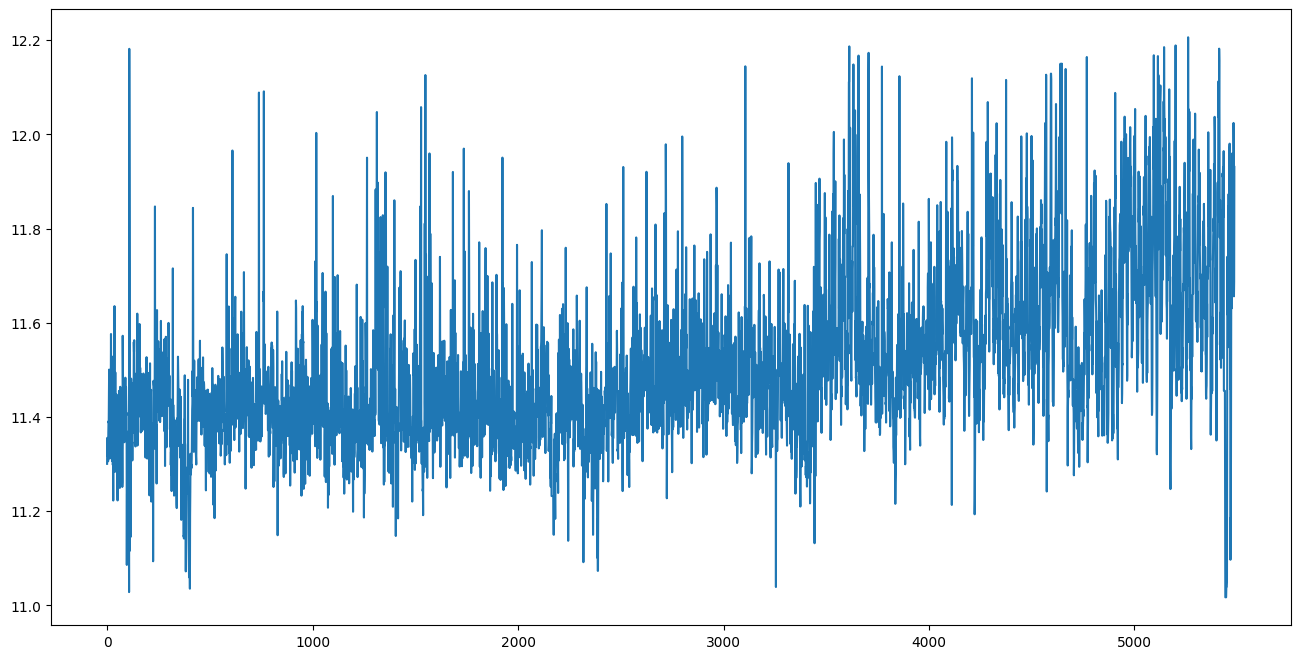

In [28]:
np.log(df_average.avgGas).plot(figsize = (16,8)); # the trend is changing, so let's take a difference

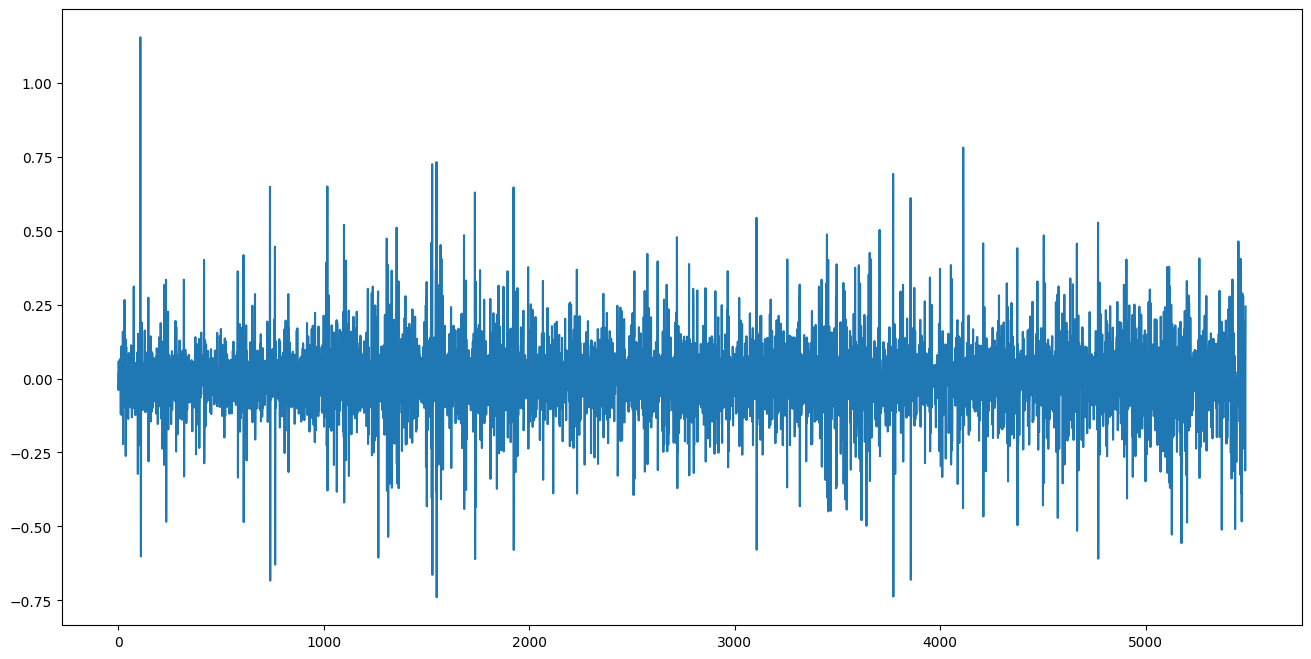

In [29]:
np.log(df_average.avgGas).diff(periods = 1).plot(figsize = (16,8)); # it is stationary, so that we will use it as inputs for our model

In [30]:
df_average.to_csv('average_gas.csv', index = False)
df_average_90days.to_csv('average_gas_90days.csv', index = False)

## Preprocessing Crypto Price Data

In [31]:
crypto_price_df = pd.read_csv('crypto_price_90days.csv')
crypto_price_df

,UNIX Timestamp,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
0,1.660000e+12,2022-09-12 10:01,22195.69118,1750.655946
1,1.660000e+12,2022-09-12 11:03,22180.53379,1746.531098
2,1.660000e+12,2022-09-12 12:04,22292.74291,1751.864674
3,1.660000e+12,2022-09-12 13:01,22359.17007,1747.678093
4,1.660000e+12,2022-09-12 14:03,22391.44726,1752.387514
...,...,...,...,...
2150,1.670000e+12,2022-12-11 6:00,17177.26840,1273.466338
2151,1.670000e+12,2022-12-11 7:01,17182.10721,1274.061867
2152,1.670000e+12,2022-12-11 8:01,17188.39360,1275.846801
2153,1.670000e+12,2022-12-11 9:00,17187.42631,1275.330135


In [32]:
crypto_price_df.drop(len(crypto_price_df) - 1, axis = 0, inplace = True)
crypto_price_df.drop('UNIX Timestamp', axis = 1, inplace = True)

In [33]:
crypto_price_df

,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
0,2022-09-12 10:01,22195.69118,1750.655946
1,2022-09-12 11:03,22180.53379,1746.531098
2,2022-09-12 12:04,22292.74291,1751.864674
3,2022-09-12 13:01,22359.17007,1747.678093
4,2022-09-12 14:03,22391.44726,1752.387514
...,...,...,...
2149,2022-12-11 5:01,17177.70161,1270.787620
2150,2022-12-11 6:00,17177.26840,1273.466338
2151,2022-12-11 7:01,17182.10721,1274.061867
2152,2022-12-11 8:01,17188.39360,1275.846801


In [34]:
def fun2(x):
    x = x[:-3] # we don't need :mm part
    x = x.split(' ')
    if len(x[1]) == 2: # example: 10
        x = ' '.join(x)
    else:
        x = ' 0'.join(x)
    return pd.to_datetime(x, format = '%Y-%m-%d %H')
    

crypto_price_df['Timestamp'] = crypto_price_df['Timestamp'].apply(fun2)

In [35]:
crypto_price_df

,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
0,2022-09-12 10:00:00,22195.69118,1750.655946
1,2022-09-12 11:00:00,22180.53379,1746.531098
2,2022-09-12 12:00:00,22292.74291,1751.864674
3,2022-09-12 13:00:00,22359.17007,1747.678093
4,2022-09-12 14:00:00,22391.44726,1752.387514
...,...,...,...
2149,2022-12-11 05:00:00,17177.70161,1270.787620
2150,2022-12-11 06:00:00,17177.26840,1273.466338
2151,2022-12-11 07:00:00,17182.10721,1274.061867
2152,2022-12-11 08:00:00,17188.39360,1275.846801


In [36]:
def check_timestamps(df):
    check = []
    for index in range(len(df) - 1):
        var1 = int(str(df.loc[index,'Timestamp'])[-8:-6]) # extract hour
        var2 = int(str(df.loc[index+1,'Timestamp'])[-8:-6])
        if (var2 - var1) % 24 != 1:
            check.extend([index, index + 1])
    return check

In [37]:
check = check_timestamps(crypto_price_df)

In [38]:
crypto_price_df.iloc[check,:] # the data from 2022-10-07 19 p.m till 2022-10-08 7 a.m does not exist
# and the data for 2022-10-04 17:00 does not exist

,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
410,2022-09-29 12:00:00,19498.02941,1339.494261
411,2022-09-29 12:00:00,19489.07544,1337.941709
411,2022-09-29 12:00:00,19489.07544,1337.941709
412,2022-09-29 12:00:00,19449.56404,1335.337360
536,2022-10-04 16:00:00,20086.85899,1353.505192
537,2022-10-04 18:00:00,19989.09172,1345.408492
550,2022-10-05 07:00:00,20228.98971,1357.485653
551,2022-10-05 07:00:00,20228.98971,1357.485653
611,2022-10-07 19:00:00,19457.30895,1324.894738
612,2022-10-08 07:00:00,19504.71322,1330.834875


In [39]:
crypto_price_df.drop([411, 412, 551, 1053, 1524, 1890], axis = 0, inplace = True)

In [40]:
crypto_price_df.loc[536:537]

,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
536,2022-10-04 16:00:00,20086.85899,1353.505192
537,2022-10-04 18:00:00,19989.09172,1345.408492


In [41]:
crypto_price_df.loc[536.5] = [pd.to_datetime('2022-10-04 17:00:00'), 20086.85899, 1353.505192]  # add a new row (now the index became a float number)

In [42]:
crypto_price_df

,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
0.0,2022-09-12 10:00:00,22195.69118,1750.655946
1.0,2022-09-12 11:00:00,22180.53379,1746.531098
2.0,2022-09-12 12:00:00,22292.74291,1751.864674
3.0,2022-09-12 13:00:00,22359.17007,1747.678093
4.0,2022-09-12 14:00:00,22391.44726,1752.387514
...,...,...,...
2150.0,2022-12-11 06:00:00,17177.26840,1273.466338
2151.0,2022-12-11 07:00:00,17182.10721,1274.061867
2152.0,2022-12-11 08:00:00,17188.39360,1275.846801
2153.0,2022-12-11 09:00:00,17187.42631,1275.330135


In [43]:
crypto_price_df = crypto_price_df.sort_index().reset_index(drop=True)
crypto_price_df

,Timestamp,Bitcoin Price (USD),Ethereum Price (USD)
0,2022-09-12 10:00:00,22195.69118,1750.655946
1,2022-09-12 11:00:00,22180.53379,1746.531098
2,2022-09-12 12:00:00,22292.74291,1751.864674
3,2022-09-12 13:00:00,22359.17007,1747.678093
4,2022-09-12 14:00:00,22391.44726,1752.387514
...,...,...,...
2144,2022-12-11 05:00:00,17177.70161,1270.787620
2145,2022-12-11 06:00:00,17177.26840,1273.466338
2146,2022-12-11 07:00:00,17182.10721,1274.061867
2147,2022-12-11 08:00:00,17188.39360,1275.846801


In [44]:
df_average_90days.set_index('timestamp', inplace = True)

In [45]:
crypto_price_df.set_index('Timestamp', inplace = True)

In [46]:
crypto_price_df.index.name = 'timestamp'

In [47]:
crypto_price_df

,Bitcoin Price (USD),Ethereum Price (USD)
timestamp,,
2022-09-12 10:00:00,22195.69118,1750.655946
2022-09-12 11:00:00,22180.53379,1746.531098
2022-09-12 12:00:00,22292.74291,1751.864674
2022-09-12 13:00:00,22359.17007,1747.678093
2022-09-12 14:00:00,22391.44726,1752.387514
...,...,...
2022-12-11 05:00:00,17177.70161,1270.787620
2022-12-11 06:00:00,17177.26840,1273.466338
2022-12-11 07:00:00,17182.10721,1274.061867


In [86]:
df_90days = pd.concat([df_average_90days, crypto_price_df], axis = 1, join = 'inner')

In [87]:
df_90days

,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
timestamp,,,,
2022-09-12 10:00:00,10.5850,92232.945200,22195.69118,1750.655946
2022-09-12 11:00:00,30.2300,88143.438267,22180.53379,1746.531098
2022-09-12 12:00:00,33.4100,82982.461422,22292.74291,1751.864674
2022-09-12 13:00:00,25.2250,84544.989353,22359.17007,1747.678093
2022-09-12 14:00:00,52.2450,89251.971497,22391.44726,1752.387514
...,...,...,...,...
2022-12-11 05:00:00,15.0511,166736.391980,17177.70161,1270.787620
2022-12-11 06:00:00,14.9330,157472.907955,17177.26840,1273.466338
2022-12-11 07:00:00,16.3310,115399.969702,17182.10721,1274.061867


In [88]:
df_90days.corr()

,average_gas_fee,avgGas,Bitcoin Price (USD),Ethereum Price (USD)
average_gas_fee,1.000000,-0.305356,0.059265,0.026005
avgGas,-0.305356,1.000000,-0.223470,-0.155227
Bitcoin Price (USD),0.059265,-0.223470,1.000000,0.862430
Ethereum Price (USD),0.026005,-0.155227,0.862430,1.000000


In [89]:
df_90days.to_csv('df_90days.csv')

In [90]:
df_90days['average_gas_fee'] = np.log(df_90days['average_gas_fee'])
for col in df_90days.columns[1:]:
    df_90days.loc[:, col] = np.log(df_90days[col]).diff(periods = 1)
df_90days.drop(pd.to_datetime('2022-09-12 10:00:00'), axis = 0, inplace = True)
df_90days.columns = ['log average_gas_fee','log diff avgGas', 'log return (Bitcoin)', 'log return (Ethereum)']
df_90days.head()

,log average_gas_fee,log diff avgGas,log return (Bitcoin),log return (Ethereum)
timestamp,,,,
2022-09-12 11:00:00,3.408835,-0.045352,-0.000683,-0.002359
2022-09-12 12:00:00,3.508855,-0.060336,0.005046,0.003049
2022-09-12 13:00:00,3.227836,0.018655,0.002975,-0.002393
2022-09-12 14:00:00,3.955944,0.054180,0.001443,0.002691
2022-09-12 15:00:00,4.347565,-0.087952,-0.004134,-0.009437


In [91]:
train_df = df_90days
train_df.to_csv('train_df_90days.csv')